In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/brandonmanley/Desktop/PhD/dijet_dsa')
import dsa_mc.dijet as dutils
import random
import pandas as pd
from scipy.interpolate import interp1d

# setup plotting
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 14  
plt.rcParams["xtick.labelsize"] = 12  
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 16  
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
%config InlineBackend.figure_format = 'retina'

In [3]:
# make small x predictions

s = 319**2
t_range = [0.1, 0.7]
x_range = [5.64*(10**(-5)), 0.01] # can be inferred from Q, s, and y ranges
Q_range = [2, np.sqrt(110)]
pT_range = [5.0, 12.0]
z_range = [0.2, 0.8] # this is a guess... but maybe one can assume 
y_range = [0.05, 0.7]

# points to plot
npoints = 20
Q_points = np.arange(Q_range[0], Q_range[1], (Q_range[1]-Q_range[0])/npoints)
pT_points = np.arange(pT_range[0], pT_range[1], (pT_range[1]-pT_range[0])/npoints)
t_points = np.arange(t_range[0], t_range[1], (t_range[1]-t_range[0])/npoints)
y_points = np.arange(y_range[0], y_range[1], (y_range[1]-y_range[0])/npoints)

dQs = []
dpTs = []
dts = []
dys = []

epsilon = 6.4
tag = 'AAMS09'
dj = dutils.DIJET(gauss_param=epsilon)


for y in y_points:
    print('y', y)
    xsec = dj.dxsec_dy(y, s, t_range, z_range, Q_range, pT_range)
    print(xsec)
    dys.append([y, xsec])
    
    dys_arr = np.array(dys)
    np.savetxt(f'predictions/pred_y_e{epsilon}_{tag}.dat', dys_arr)
print('saved y predictions with tag', tag)
    

for Q in Q_points:
    print('Q', Q)
    xsec = dj.dxsec_dQ2(Q, s, x_range, z_range, pT_range, t_range)
    print(xsec)
    dQs.append([Q, xsec])
    
    dQs_arr = np.array(dQs)
    np.savetxt(f'predictions/pred_Q2_e{epsilon}_{tag}.dat', dQs_arr)
print('saved Q predictions with tag', tag)

for pT in pT_points:
    print('pT', pT)
    xsec = dj.dxsec_dpT(pT, s, x_range, z_range, Q_range, t_range)
    print(xsec)
    dpTs.append([pT, xsec])
    
    dpTs_arr = np.array(dpTs)
    np.savetxt(f'predictions/pred_pT_e{epsilon}_{tag}.dat', dpTs_arr)
print('saved pT predictions with tag', tag)

for it, t in enumerate(t_points):
    print('t', t)
    if it == 0: xsec = dj.dxsec_dt(t, s, x_range, z_range, Q_range, pT_range)
    else: pass
    print(xsec)
    dts.append([t, xsec])
    
    dts_arr = np.array(dts)
    np.savetxt(f'predictions/pred_t_e{epsilon}_{tag}.dat', dts_arr)
print('saved t predictions with tag', tag)

    

Using N data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/narr_ymin4.61_ymax14.91_AAMS09.dat
loaded params from replica_params_old.csv
y 0.05
skipping x=0.01025502342456122
skipping x=0.012192723699399163
skipping x=0.014297999934530646
skipping x=0.016570852129955665
skipping x=0.019011280285674212
skipping x=0.021619284401686305
928.3240486347042
y 0.08249999999999999
skipping x=0.010042940684821616
skipping x=0.011521988051923766
skipping x=0.01310259660708261
734.7095634749562
y 0.11499999999999998
615.9273279081335
y 0.14749999999999996
525.1130998160382
y 0.17999999999999994
459.40201190555695
y 0.21249999999999994
409.09764994077307
y 0.24499999999999994
367.6277867203922
y 0.2774999999999999
334.3358833611803
y 0.3099999999999999
305.5427258280682
y 0.3424999999999999
281.0164161537122
y 0.3749999999999999
259.6109218508379
y 0.40749999999999986
240.6022213594169
y 0.43999999999999984
224.53663734342462
y 0.4724999999999998
209.74826069275267
y 0.5049999999999

In [5]:
# load H1 data and predictions

data_df = {}
preds = {}
# pred_tags = ['e6.4_Qs2_0.1', 'e6.4_Qs2_0.2', 'e6.4_Qs2_0.3']
pred_tags = ['e6.4_AAMS09']

for ivar in ['Q2', 'pT', 't', 'y']:
    data_df[ivar] = pd.read_excel('H1dijet.xlsx', sheet_name=f'd{ivar}')
    data_df[ivar]['error'] = data_df[ivar]['sigma']*0.01*data_df[ivar]['rel_error']
    data_df[ivar][f'{ivar}avg'] = (data_df[ivar][f'{ivar}min'] + data_df[ivar][f'{ivar}max'])/2

    preds[ivar] = {}
    for tag in pred_tags:
        preds[ivar][tag] = np.loadtxt(f'predictions/pred_{ivar}_{tag}.dat')



In [7]:
# calculate ratios with data

ratios = {} 
for ivar in ['Q2', 'pT', 't', 'y']:
    ratios[ivar] = {}
    for tag in pred_tags:
        xs = preds[ivar][tag][:, 0]
        if ivar == 'Q2': xs *= xs
        values = preds[ivar][tag][:, 1]
        
        interp = interp1d(xs, values, kind='linear', bounds_error=False, fill_value='extrapolate')
        ratios[ivar][tag] = interp(data_df[ivar][f'{ivar}avg'].to_numpy())/data_df[ivar]['sigma'].to_numpy()



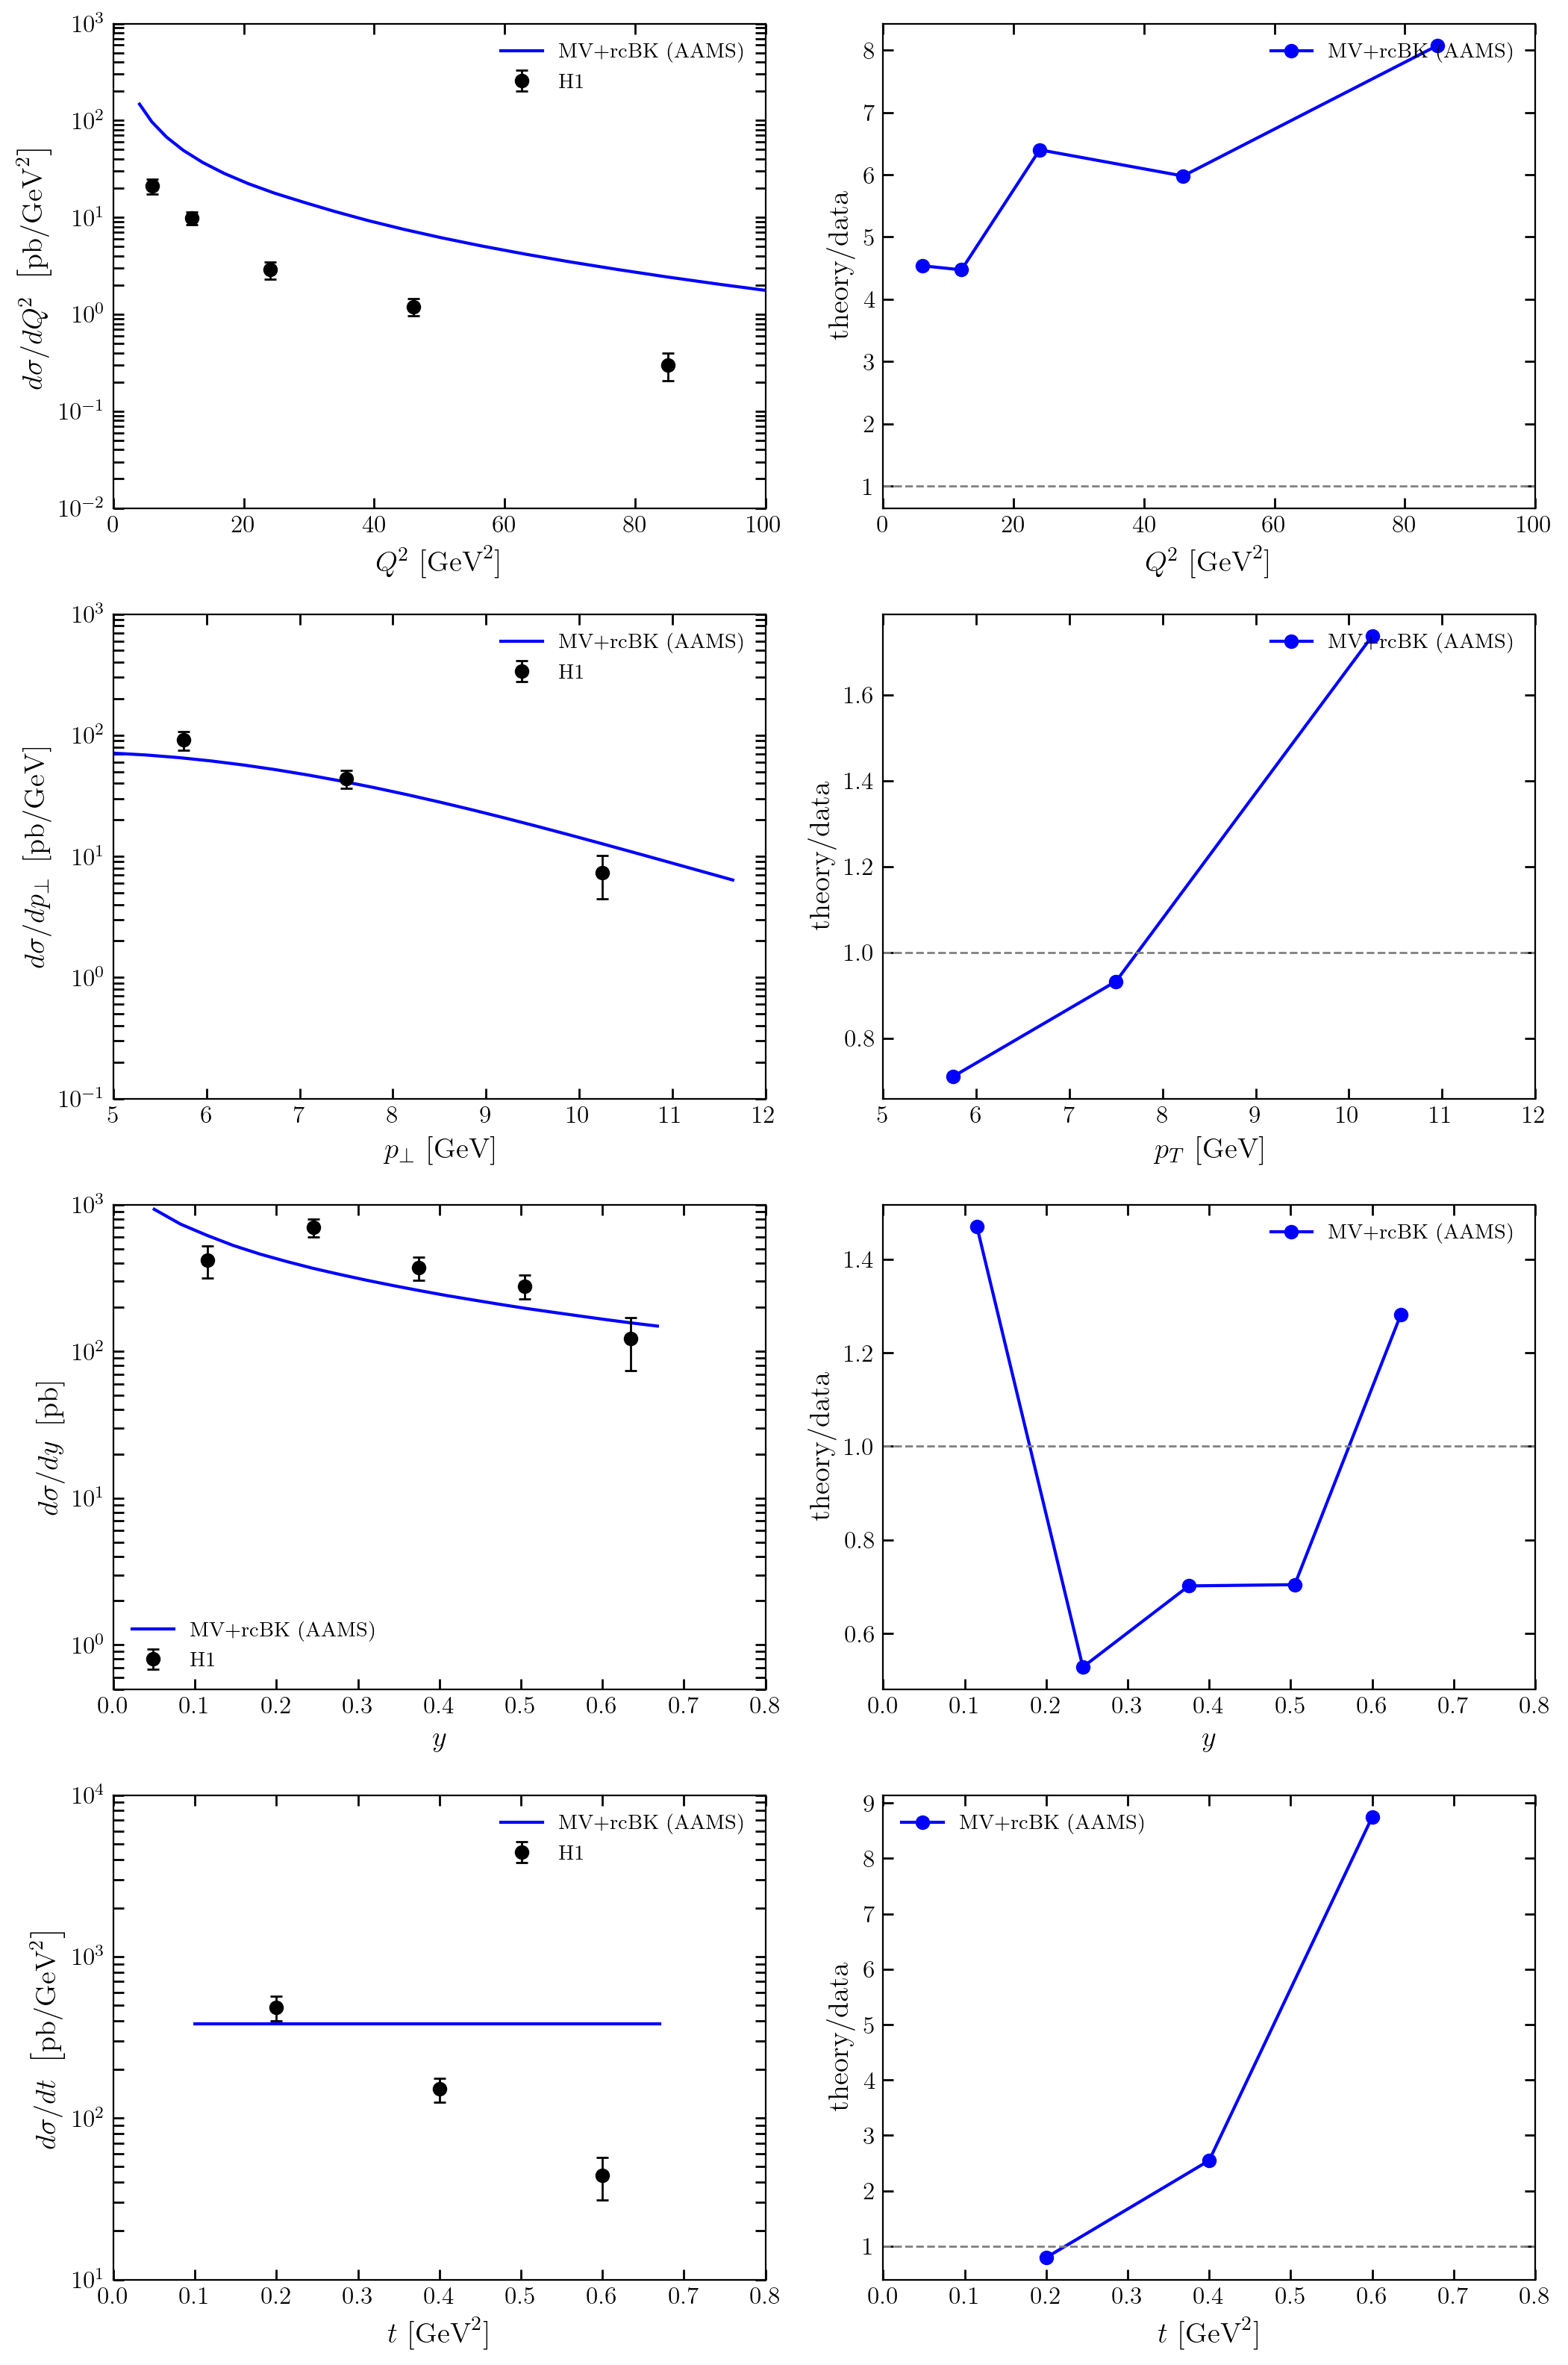

In [13]:
# plot data w/ predictions
asp_ratio = (4/3)*1.0
psize = 4
nplots = 4

fig, axs = plt.subplots(nplots, 2, figsize=(asp_ratio*psize*2, psize*nplots))

axs[0,0].errorbar(
    data_df['Q2']['Q2avg'], data_df['Q2']['sigma'], yerr=data_df['Q2']['error'], label=r'H1',
    fmt='o', 
    capsize=3, elinewidth=1, capthick=1, color='black'
)

# theory_labels = [r'MV+rcBK $(Q_{s0}^2 = 0.1\, \mathrm{GeV}^2)$', 
#                  r'MV+rcBK $(Q_{s0}^2 = 0.2\, \mathrm{GeV}^2)$', 
#                  r'MV+rcBK $(Q_{s0}^2 = 0.3\, \mathrm{GeV}^2)$']
# theory_labels = [r'MV $(Q_{s0}^2 = 0.1\, \mathrm{GeV}^2)$',
#                  r'MV $(Q_{s0}^2 = 0.2\, \mathrm{GeV}^2)$',
#                  r'MV $(Q_{s0}^2 = 0.3\, \mathrm{GeV}^2)$'
#                 ]
theory_labels = [r'MV+rcBK (AAMS)']

colors = ['blue', 'red', 'green', 'gray', 'orange']
lines = ['-', '--', '-.', ':']
marks = ['o', '^', 'D', 'v']

for itag, tag in enumerate(pred_tags):
    for ivar, var in enumerate(['Q2', 'pT', 'y', 't']):
        axs[ivar,0].plot(preds[var][tag][:, 0], preds[var][tag][:, 1], label=theory_labels[itag], color=colors[itag], linestyle=lines[itag])
        axs[ivar,1].plot(data_df[var][f'{var}avg'], ratios[var][tag], f'{lines[itag]}{marks[itag]}', label=theory_labels[itag], color=colors[itag])

    
axs[0,0].set_xlabel(r'$Q^2 \,\, [\mathrm{GeV}^2]$')
axs[0,0].set_ylabel(r'$d \sigma / dQ^2 \,\, \left[\mathrm{pb}/\mathrm{GeV}^{2} \right]$')
axs[0,0].legend(frameon=False, fontsize='small')
axs[0,0].semilogy()
axs[0,0].set_xlim([0, 100])
axs[0,0].set_ylim([10**(-2), 1000])
axs[0,0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)


axs[1,0].errorbar(
    data_df['pT']['pTavg'], data_df['pT']['sigma'], yerr=data_df['pT']['error'], label=r'H1',
    fmt='o', 
    capsize=3, elinewidth=1, capthick=1, color='black'
)


axs[1,0].set_xlabel(r'$p_{\perp} \,\, [\mathrm{GeV}]$')
axs[1,0].set_ylabel(r'$d \sigma / dp_{\perp} \,\, \left[\mathrm{pb}/\mathrm{GeV} \right]$')
axs[1,0].legend(frameon=False, fontsize='small')
axs[1,0].semilogy()
axs[1,0].set_xlim([5, 12])
axs[1,0].set_ylim([10**(-1), 1000])
axs[1,0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)


axs[2,0].errorbar(
    data_df['y']['yavg'], data_df['y']['sigma'], yerr=data_df['y']['error'], label=r'H1',
    fmt='o', 
    capsize=3, elinewidth=1, capthick=1, color='black'
)


axs[2,0].set_xlabel(r'$y$')
axs[2,0].set_ylabel(r'$d \sigma / dy \,\, \left[\mathrm{pb}\right]$')
axs[2,0].legend(frameon=False, fontsize='small')
axs[2,0].semilogy()
axs[2,0].set_xlim([0, 0.8])
axs[2,0].set_ylim([5*(10**(-1)), 1000])
axs[2,0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)


axs[3,0].errorbar(
    data_df['t']['tavg'], data_df['t']['sigma'], yerr=data_df['t']['error'], label=r'H1',
    fmt='o', 
    capsize=3, elinewidth=1, capthick=1, color='black'
)


axs[3,0].set_xlabel(r'$t \,\, [\mathrm{GeV}^2]$')
axs[3,0].set_ylabel(r'$d \sigma / dt \,\, \left[\mathrm{pb}/\mathrm{GeV}^2\right]$')
axs[3,0].legend(frameon=False, fontsize='small', loc='upper right')
axs[3,0].semilogy()
axs[3,0].set_xlim([0, 0.8])
axs[3,0].set_ylim([10, 10000])
axs[3,0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)


# ratio plots
axs[0,1].set_xlabel(r'$Q^2 \,\, [\mathrm{GeV}^2]$')
axs[0,1].set_ylabel('theory/data')
# axs[0,1].semilogy()
axs[0,1].set_xlim([0, 100])
axs[0,1].axhline(y=1, color='gray', linestyle='--', linewidth=1)
axs[0,1].legend(frameon=False, fontsize='small', loc='upper right')
axs[0,1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)

axs[1,1].set_xlabel(r'$p_T \,\, [\mathrm{GeV}]$')
axs[1,1].set_ylabel('theory/data')
# axs[1,1].semilogy()
axs[1,1].set_xlim([5, 12])
axs[1,1].axhline(y=1, color='gray', linestyle='--', linewidth=1)
axs[1,1].legend(frameon=False,fontsize='small', loc='upper right')
axs[1,1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)

axs[2,1].set_xlabel(r'$y$')
axs[2,1].set_ylabel('theory/data')
# axs[2,1].semilogy()
axs[2,1].set_xlim([0, 0.8])
axs[2,1].axhline(y=1, color='gray', linestyle='--', linewidth=1)
axs[2,1].legend(frameon=False, fontsize='small', loc='upper right')
axs[2,1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)

axs[3,1].set_xlabel(r'$t \,\, [\mathrm{GeV}^2]$')
axs[3,1].set_ylabel('theory/data')
# axs[3,1].semilogy()
axs[3,1].set_xlim([0, 0.8])
axs[3,1].axhline(y=1, color='gray', linestyle='--', linewidth=1)
axs[3,1].legend(frameon=False, fontsize='small', loc='upper left')
axs[3,1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)

plt.tight_layout()
plt.show()